<a href="https://colab.research.google.com/github/subhrajyoti-ghosh/ML-and-Deep-Learning/blob/main/Comv_AutoEcoder_Img_SR_V3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
if os.path.exists("/content/DIV2K_train_HR.zip"):
  os.remove("/content/DIV2K_train_HR.zip")

### Download DIV2K_train_HR dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2023-03-15 14:08:58--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2023-03-15 14:08:58--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  15.5MB/s    in 4m 19s  

2023-03-15 14:13:19 (13.0 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:
if os.path.exists("/content/DIV2K_valid_HR.zip"):
  os.remove("/content/DIV2K_valid_HR.zip")

### Download DIV2K_valid_HR dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2023-03-15 14:13:19--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2023-03-15 14:13:19--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  12.9MB/s    in 37s     

2023-03-15 14:13:57 (11.7 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]



In [ ]:
from zipfile import ZipFile

### Unzip the datasets

In [ ]:
with ZipFile("DIV2K_train_HR.zip", 'r') as zObject:
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="/content/")

In [ ]:
with ZipFile("DIV2K_valid_HR.zip", 'r') as zObject:
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="/content/")

### Import Library

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers, layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import os
from PIL import Image
import math
import pandas as pd
from tqdm import tqdm

### Create function to calculate Root Mean Square Error

In [ ]:
def find_rmse(test_img, org_img):
    cnt = 0
    tot_diff = 0
    for elem in range(len(test_img)):
        sqr_diff = (test_img[elem] - org_img[elem])**2
        tot_diff = tot_diff + sqr_diff
        
        #cnt = cnt + 1
    
    rmse = math.sqrt(tot_diff/len(test_img))
    return rmse

In [ ]:
def find_rmse(test_img, org_img):
    #cnt = 0
    #tot_diff = 0
    """for elem in range(len(test_img)):
        sqr_diff = (test_img[elem] - org_img[elem])**2
        tot_diff = tot_diff + sqr_diff
        
        #cnt = cnt + 1
    """
    rmse = np.sqrt(sum((test_img-org_img)**2)/len(org_img))
    return rmse

### This model can only process a specific magnification factor. Also to process large images, we need large processing power. Hence the HR images are down-sampled to 256 X 256 and 64 X 64. We will treat 256 X 256 as HR image and 64 X 64 mage as LR image

In [ ]:
if os.path.exists("/content/Size_64") == False:
  os.makedirs("/content/Size_64")
if os.path.exists("/content/Size_256") == False:
  os.makedirs("/content/Size_256")

In [ ]:
if os.path.exists("/content/Val_Size_64") == False:
  os.makedirs("/content/Val_Size_64")
if os.path.exists("/content/Val_Size_256") == False:
  os.makedirs("/content/Val_Size_256")

In [ ]:
img_64 = []
img_256 = []

In [ ]:
for file in os.listdir("/content/DIV2K_train_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_train_HR/",file), target_size=(64,64,3))
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_64",file),img)

In [ ]:
for file in os.listdir("/content/DIV2K_train_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_train_HR/",file), target_size=(256,256,3))
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_256",file),img)

In [ ]:
for file in os.listdir("/content/DIV2K_valid_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_valid_HR/",file), target_size=(64,64,3))
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Val_Size_64",file),img)

In [ ]:
for file in os.listdir("/content/DIV2K_valid_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_valid_HR/",file), target_size=(256,256,3))
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Val_Size_256",file),img)

In [ ]:
for file in os.listdir("/content/Size_64"):
  img = tf.keras.utils.load_img(os.path.join("/content/Size_64",file))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  img_64.append(img)

In [ ]:
for file in os.listdir("/content/Size_256"):
  img = tf.keras.utils.load_img(os.path.join("/content/Size_256",file))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  img_256.append(img)

In [ ]:
arr_img_64 = np.array(img_64)
arr_img_256 = np.array(img_256)

In [ ]:
arr_img_64.shape,arr_img_256.shape

((800, 64, 64, 3), (800, 256, 256, 3))

#### Autoencoder with scale factor 4

In [ ]:
# Define the dimensions of the input images and the scaling factor
input_shape = (64, 64, 3)
hr_shape = (256, 256, 3)

scale_factor = hr_shape[0] // input_shape[0]

# Define the encoder layers
encoder_input = Input(shape=input_shape)
encoder_conv1 = Conv2D(64, 3, activation="relu", padding="same", name = "en_Conv1")(encoder_input)
encoder_pool1 = MaxPooling2D(padding="same", name = "en_Pool1")(encoder_conv1)
encoder_conv2 = Conv2D(128, 3, activation="relu", padding="same", name = "en_Conv2")(encoder_pool1)
#encoder_pool2 = MaxPooling2D(padding="same", name = "en_Pool2")(encoder_conv2)
#encoder_conv3 = Conv2D(256, 3, activation="relu", padding="same", name = "en_Conv3")(encoder_pool2)

# Define the decoder layers
#decoder_conv1 = Conv2DTranspose(128, 3, activation="relu", strides = 2, padding="same", name = "dc_Conv1T")(encoder_conv3)
#decoder_conv1 = Conv2DTranspose(128, 3, activation="relu", strides = 1, padding="same", name = "dc_Conv1T")(encoder_conv2)
decoder_conv2 = Conv2DTranspose(128, 3, activation="relu", strides = 2, padding="same", name = "dc_Conv2T")(encoder_conv2)
decoder_conv3 = Conv2DTranspose(128, 3, activation="relu", strides = 2, padding="same", name = "dc_Conv3T")(decoder_conv2)
decoder_conv4 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name = "dc_Conv4T")(decoder_conv3)
decoder_output = Conv2D(hr_shape[-1], 3, activation="sigmoid", padding="same", name = "dc_Conv3")(decoder_conv4)

# Define the autoencoder model
autoencoder = Model(encoder_input, decoder_output)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 en_Conv1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 en_Pool1 (MaxPooling2D)     (None, 32, 32, 64)        0         
                                                                 
 en_Conv2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 dc_Conv2T (Conv2DTranspose)  (None, 64, 64, 128)      147584    
                                                                 
 dc_Conv3T (Conv2DTranspose)  (None, 128, 128, 128)    147584    
                                                                 
 dc_Conv4T (Conv2DTranspose)  (None, 256, 256, 64)     73792 

### Compile the autoencoder with optimizer = "adam" and loss = "mean_squared_error"

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

### Train the model with 10 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=10)

Epoch 1/10
25/25 [==============================] - 20s 245ms/step - loss: 0.0699
Epoch 2/10
25/25 [==============================] - 6s 249ms/step - loss: 0.0391
Epoch 3/10
25/25 [==============================] - 6s 253ms/step - loss: 0.0292
Epoch 4/10
25/25 [==============================] - 7s 262ms/step - loss: 0.0260
Epoch 5/10
25/25 [==============================] - 6s 256ms/step - loss: 0.0227
Epoch 6/10
25/25 [==============================] - 7s 265ms/step - loss: 0.0205
Epoch 7/10
25/25 [==============================] - 7s 269ms/step - loss: 0.0197
Epoch 8/10
25/25 [==============================] - 7s 272ms/step - loss: 0.0193
Epoch 9/10
25/25 [==============================] - 7s 272ms/step - loss: 0.0193
Epoch 10/10
25/25 [==============================] - 7s 268ms/step - loss: 0.0189


### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 3s 104ms/step


In [ ]:
pred_arr_img_256.shape

(800, 256, 256, 3)

### View one sample image from original set and predicted set and visually check quality

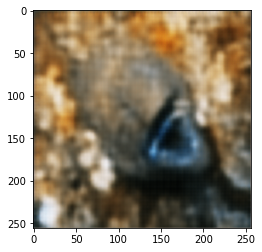

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

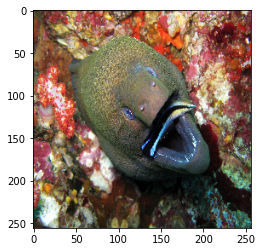

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

In [ ]:
df_perf = pd.DataFrame(columns=["Model","LossFunction","Optimizer","epochs","Img_id","Error_Method","Error"])

In [ ]:
df_perf.shape

(0, 7)

### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 10
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:25<00:00, 31.00it/s]


In [ ]:
df_perf

,Model,LossFunction,Optimizer,epochs,Img_id,Error_Method,Error
0,Autoencoder 1,RSME,adam,10,0,RSME,0.122580
0,Autoencoder 1,RSME,adam,10,1,RSME,0.152733
0,Autoencoder 1,RSME,adam,10,2,RSME,0.132709
0,Autoencoder 1,RSME,adam,10,3,RSME,0.143577
0,Autoencoder 1,RSME,adam,10,4,RSME,0.142966
...,...,...,...,...,...,...,...
0,Autoencoder 1,RSME,adam,10,795,RSME,0.188174
0,Autoencoder 1,RSME,adam,10,796,RSME,0.213566
0,Autoencoder 1,RSME,adam,10,797,RSME,0.094564
0,Autoencoder 1,RSME,adam,10,798,RSME,0.145897


### Train the model with 20 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=20)

Epoch 1/20
25/25 [==============================] - 7s 264ms/step - loss: 0.0188
Epoch 2/20
25/25 [==============================] - 7s 268ms/step - loss: 0.0186
Epoch 3/20
25/25 [==============================] - 7s 268ms/step - loss: 0.0184
Epoch 4/20
25/25 [==============================] - 7s 265ms/step - loss: 0.0184
Epoch 5/20
25/25 [==============================] - 7s 264ms/step - loss: 0.0187
Epoch 6/20
25/25 [==============================] - 7s 261ms/step - loss: 0.0183
Epoch 7/20
25/25 [==============================] - 7s 262ms/step - loss: 0.0182
Epoch 8/20
25/25 [==============================] - 6s 259ms/step - loss: 0.0181
Epoch 9/20
25/25 [==============================] - 7s 261ms/step - loss: 0.0180
Epoch 10/20
25/25 [==============================] - 6s 260ms/step - loss: 0.0177
Epoch 11/20
25/25 [==============================] - 7s 260ms/step - loss: 0.0173
Epoch 12/20
25/25 [==============================] - 7s 261ms/step - loss: 0.0172
Epoch 13/20
25/25 [======

### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 100ms/step


### View one sample image from original set and predicted set and visually check quality

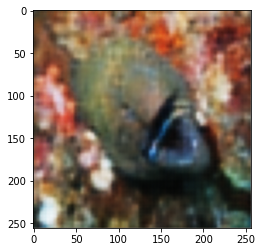

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 20
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 33.13it/s]


In [ ]:
df_perf

,Model,LossFunction,Optimizer,epochs,Img_id,Error_Method,Error
0,Autoencoder 1,RSME,adam,10,0,RSME,0.122580
0,Autoencoder 1,RSME,adam,10,1,RSME,0.152733
0,Autoencoder 1,RSME,adam,10,2,RSME,0.132709
0,Autoencoder 1,RSME,adam,10,3,RSME,0.143577
0,Autoencoder 1,RSME,adam,10,4,RSME,0.142966
...,...,...,...,...,...,...,...
0,Autoencoder 1,RSME,adam,20,795,RSME,0.185919
0,Autoencoder 1,RSME,adam,20,796,RSME,0.205241
0,Autoencoder 1,RSME,adam,20,797,RSME,0.081461
0,Autoencoder 1,RSME,adam,20,798,RSME,0.136566


In [ ]:
df_perf.epochs.unique()

array([10, 20], dtype=object)

### Train the model with 30 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=30)

Epoch 1/30
25/25 [==============================] - 7s 266ms/step - loss: 0.0169
Epoch 2/30
25/25 [==============================] - 7s 272ms/step - loss: 0.0169
Epoch 3/30
25/25 [==============================] - 7s 271ms/step - loss: 0.0168
Epoch 4/30
25/25 [==============================] - 7s 268ms/step - loss: 0.0167
Epoch 5/30
25/25 [==============================] - 7s 264ms/step - loss: 0.0167
Epoch 6/30
25/25 [==============================] - 7s 262ms/step - loss: 0.0167
Epoch 7/30
25/25 [==============================] - 6s 259ms/step - loss: 0.0168
Epoch 8/30
25/25 [==============================] - 6s 258ms/step - loss: 0.0167
Epoch 9/30
25/25 [==============================] - 6s 257ms/step - loss: 0.0166
Epoch 10/30
25/25 [==============================] - 6s 258ms/step - loss: 0.0166
Epoch 11/30
25/25 [==============================] - 6s 259ms/step - loss: 0.0165
Epoch 12/30
25/25 [==============================] - 6s 260ms/step - loss: 0.0167
Epoch 13/30
25/25 [======

### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 100ms/step


### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 30
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 33.10it/s]


In [ ]:
df_perf

,Model,LossFunction,Optimizer,epochs,Img_id,Error_Method,Error
0,Autoencoder 1,RSME,adam,10,0,RSME,0.122580
0,Autoencoder 1,RSME,adam,10,1,RSME,0.152733
0,Autoencoder 1,RSME,adam,10,2,RSME,0.132709
0,Autoencoder 1,RSME,adam,10,3,RSME,0.143577
0,Autoencoder 1,RSME,adam,10,4,RSME,0.142966
...,...,...,...,...,...,...,...
0,Autoencoder 1,RSME,adam,30,795,RSME,0.186031
0,Autoencoder 1,RSME,adam,30,796,RSME,0.203676
0,Autoencoder 1,RSME,adam,30,797,RSME,0.077993
0,Autoencoder 1,RSME,adam,30,798,RSME,0.134688


In [ ]:
df_perf["epochs"].unique()

array([10, 20, 30], dtype=object)

### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index().sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
2,30,0.122039
1,20,0.123724
0,10,0.134565


In [ ]:
def addlabels(x,y,ax):
    for i in range(len(y)):
        ax.text(i-1,y[i],str(y[i]))

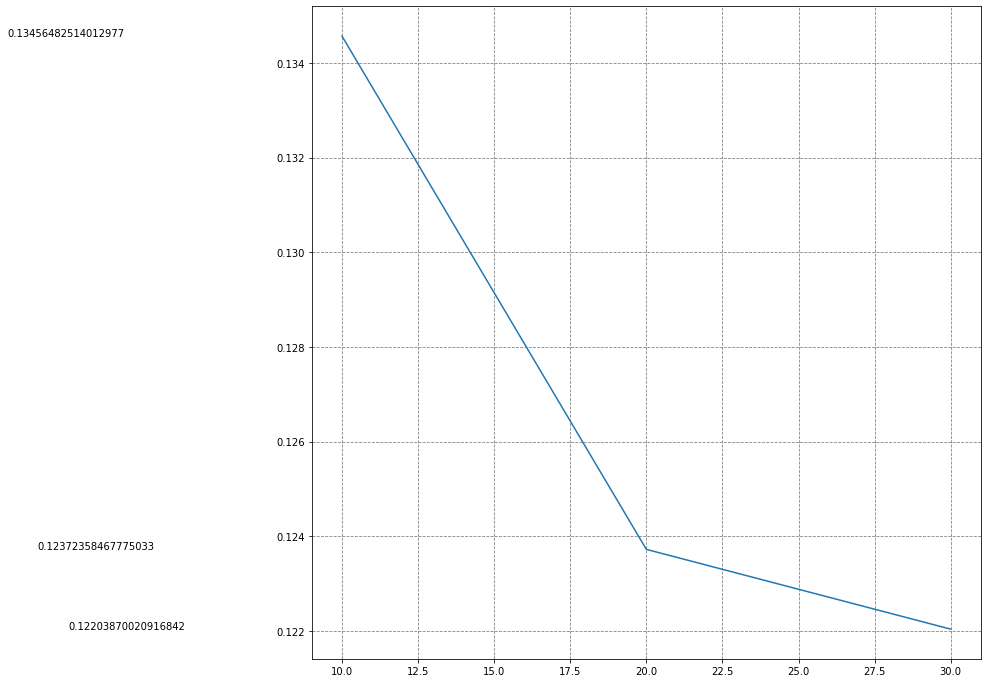

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

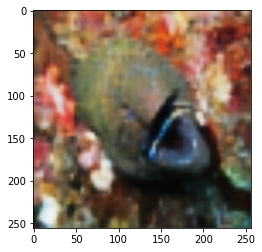

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

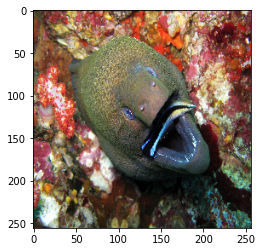

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### From above steps, we find that predicted image quality keeps on increasing with the number of epochs

### Train the model with 50 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=50)

Epoch 1/50
25/25 [==============================] - 7s 265ms/step - loss: 0.0164
Epoch 2/50
25/25 [==============================] - 7s 273ms/step - loss: 0.0164
Epoch 3/50
25/25 [==============================] - 7s 273ms/step - loss: 0.0163
Epoch 4/50
25/25 [==============================] - 7s 269ms/step - loss: 0.0162
Epoch 5/50
25/25 [==============================] - 7s 263ms/step - loss: 0.0162
Epoch 6/50
25/25 [==============================] - 7s 262ms/step - loss: 0.0162
Epoch 7/50
25/25 [==============================] - 6s 260ms/step - loss: 0.0162
Epoch 8/50
25/25 [==============================] - 6s 258ms/step - loss: 0.0162
Epoch 9/50
25/25 [==============================] - 6s 258ms/step - loss: 0.0163
Epoch 10/50
25/25 [==============================] - 6s 256ms/step - loss: 0.0164
Epoch 11/50
25/25 [==============================] - 6s 259ms/step - loss: 0.0162
Epoch 12/50
25/25 [==============================] - 6s 259ms/step - loss: 0.0162
Epoch 13/50
25/25 [======

### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 101ms/step


### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 50
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 32.84it/s]


### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index().sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
3,50,0.120606
2,30,0.122039
1,20,0.123724
0,10,0.134565


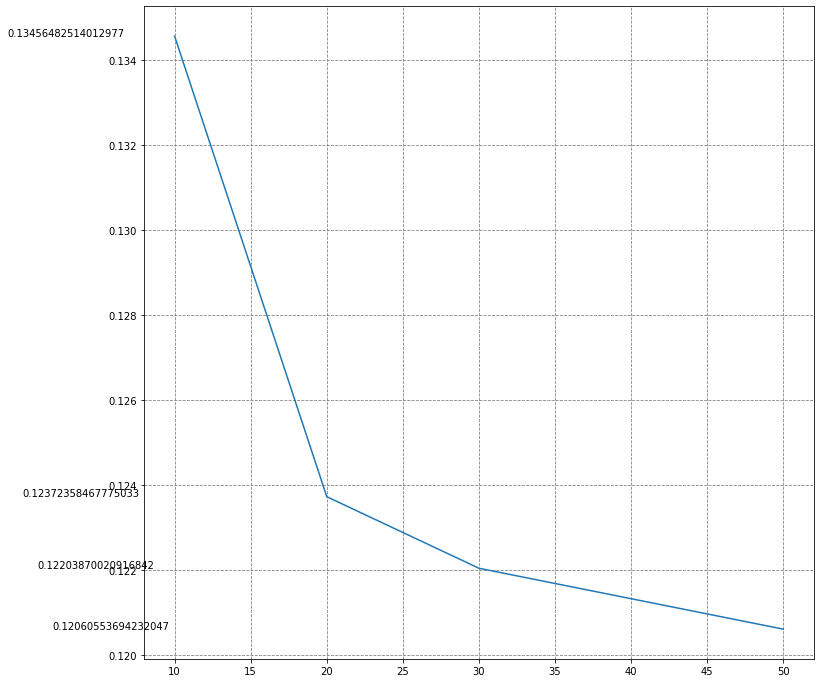

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

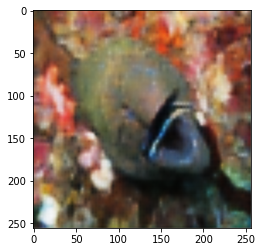

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

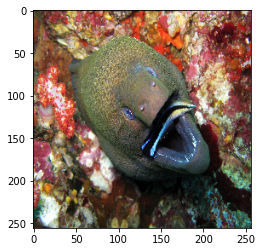

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### Train the model with 100 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=100)

Epoch 1/100
25/25 [==============================] - 7s 259ms/step - loss: 0.0157
Epoch 2/100
25/25 [==============================] - 7s 264ms/step - loss: 0.0156
Epoch 3/100
25/25 [==============================] - 7s 267ms/step - loss: 0.0155
Epoch 4/100
25/25 [==============================] - 7s 269ms/step - loss: 0.0156
Epoch 5/100
25/25 [==============================] - 7s 268ms/step - loss: 0.0156
Epoch 6/100
25/25 [==============================] - 7s 266ms/step - loss: 0.0156
Epoch 7/100
25/25 [==============================] - 7s 262ms/step - loss: 0.0155
Epoch 8/100
25/25 [==============================] - 7s 261ms/step - loss: 0.0156
Epoch 9/100
25/25 [==============================] - 6s 257ms/step - loss: 0.0155
Epoch 10/100
25/25 [==============================] - 6s 259ms/step - loss: 0.0155
Epoch 11/100
25/25 [==============================] - 6s 258ms/step - loss: 0.0156
Epoch 12/100
25/25 [==============================] - 6s 259ms/step - loss: 0.0155
Epoch 13/100


### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 102ms/step


### Calculate RMSE between original and predicted images

In [ ]:
df_perf = df_perf[df_perf["epochs"] != 100].copy()

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 100
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 33.24it/s]


### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index()#.sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
0,10,0.134565
1,20,0.123724
2,30,0.122039
3,50,0.120606
4,100,0.118724


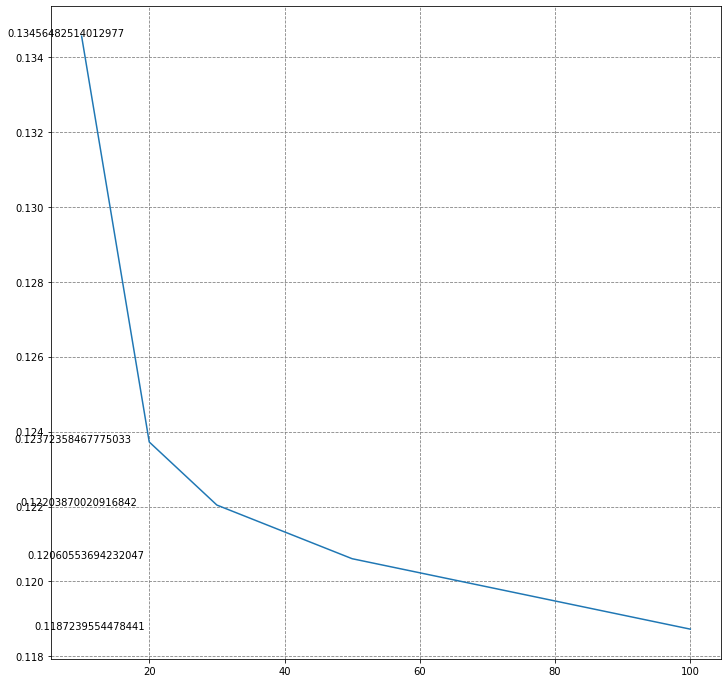

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

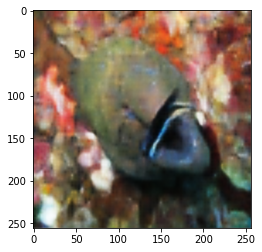

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

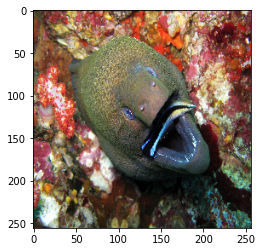

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### Train the model with 200 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=200)

Epoch 1/200
25/25 [==============================] - 7s 264ms/step - loss: 0.0152
Epoch 2/200
25/25 [==============================] - 7s 268ms/step - loss: 0.0152
Epoch 3/200
25/25 [==============================] - 7s 277ms/step - loss: 0.0152
Epoch 4/200
25/25 [==============================] - 7s 265ms/step - loss: 0.0152
Epoch 5/200
25/25 [==============================] - 7s 262ms/step - loss: 0.0152
Epoch 6/200
25/25 [==============================] - 6s 258ms/step - loss: 0.0153
Epoch 7/200
25/25 [==============================] - 6s 258ms/step - loss: 0.0152
Epoch 8/200
25/25 [==============================] - 6s 256ms/step - loss: 0.0153
Epoch 9/200
25/25 [==============================] - 6s 255ms/step - loss: 0.0153
Epoch 10/200
25/25 [==============================] - 6s 254ms/step - loss: 0.0152
Epoch 11/200
25/25 [==============================] - 6s 256ms/step - loss: 0.0151
Epoch 12/200
25/25 [==============================] - 6s 256ms/step - loss: 0.0152
Epoch 13/200


### Predict test set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 101ms/step


### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 200
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 33.17it/s]


### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index().sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
5,200,0.117103
4,100,0.118724
3,50,0.120606
2,30,0.122039
1,20,0.123724
0,10,0.134565


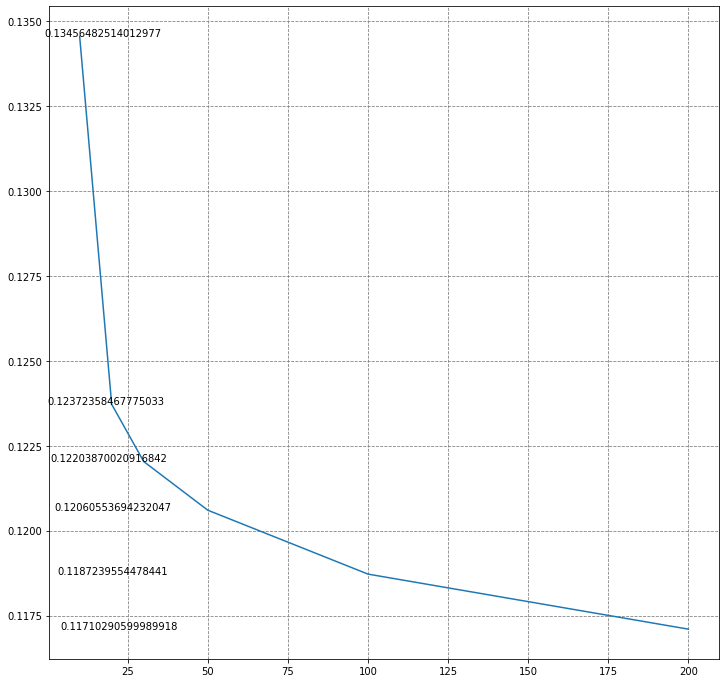

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

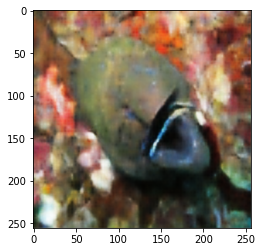

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

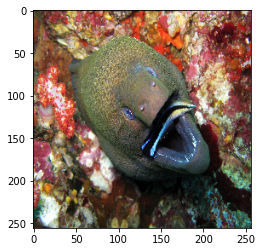

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### Train the model with 400 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=400)

Epoch 1/400
25/25 [==============================] - 6s 256ms/step - loss: 0.0146
Epoch 2/400
25/25 [==============================] - 6s 259ms/step - loss: 0.0146
Epoch 3/400
25/25 [==============================] - 7s 262ms/step - loss: 0.0145
Epoch 4/400
25/25 [==============================] - 7s 265ms/step - loss: 0.0146
Epoch 5/400
25/25 [==============================] - 7s 263ms/step - loss: 0.0146
Epoch 6/400
25/25 [==============================] - 7s 262ms/step - loss: 0.0144
Epoch 7/400
25/25 [==============================] - 6s 257ms/step - loss: 0.0145
Epoch 8/400
25/25 [==============================] - 6s 257ms/step - loss: 0.0145
Epoch 9/400
25/25 [==============================] - 6s 254ms/step - loss: 0.0145
Epoch 10/400
25/25 [==============================] - 6s 255ms/step - loss: 0.0145
Epoch 11/400
25/25 [==============================] - 6s 253ms/step - loss: 0.0145
Epoch 12/400
25/25 [==============================] - 6s 255ms/step - loss: 0.0146
Epoch 13/400


### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 101ms/step


### Calculate RMSE between original and predicted images

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 400
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:24<00:00, 32.91it/s]


### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index().sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
6,400,0.112095
5,200,0.117103
4,100,0.118724
3,50,0.120606
2,30,0.122039
1,20,0.123724
0,10,0.134565


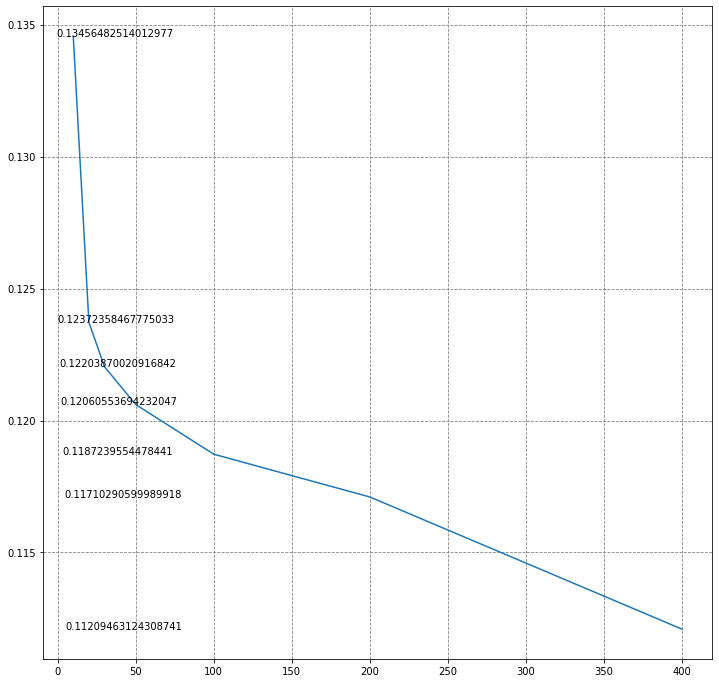

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

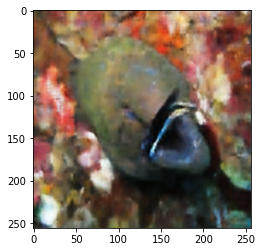

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

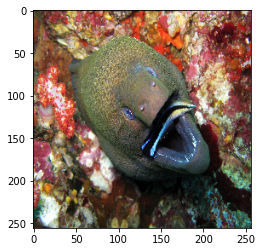

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### Train the model with 1000 Epochs

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 20s 245ms/step - loss: 0.0666
Epoch 2/1000
25/25 [==============================] - 6s 246ms/step - loss: 0.0324
Epoch 3/1000
25/25 [==============================] - 6s 251ms/step - loss: 0.0257
Epoch 4/1000
25/25 [==============================] - 6s 251ms/step - loss: 0.0218
Epoch 5/1000
25/25 [==============================] - 6s 254ms/step - loss: 0.0212
Epoch 6/1000
25/25 [==============================] - 6s 255ms/step - loss: 0.0200
Epoch 7/1000
25/25 [==============================] - 6s 258ms/step - loss: 0.0197
Epoch 8/1000
25/25 [==============================] - 7s 260ms/step - loss: 0.0193
Epoch 9/1000
25/25 [==============================] - 7s 264ms/step - loss: 0.0191
Epoch 10/1000
25/25 [==============================] - 7s 266ms/step - loss: 0.0189
Epoch 11/1000
25/25 [==============================] - 7s 270ms/step - loss: 0.0189
Epoch 12/1000
25/25 [==============================] - 7s 270ms/step - loss: 0.0186


### Predict train set to find error in dataset

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 3s 100ms/step


### Calculate RMSE between original and predicted images

In [ ]:
df_perf.shape

(5600, 7)

In [ ]:
df_perf["epochs"].unique()

array([10, 20, 30, 50, 100, 200, 400], dtype=object)

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        
                                                        "Model" : "Autoencoder 1"
                                                        ,"LossFunction" : "RSME"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 1000
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:26<00:00, 29.86it/s]


In [ ]:
df_perf["epochs"].unique()

array([10, 20, 30, 50, 100, 200, 400, 1000], dtype=object)

### Analyze model performance based on different number of epochs

In [ ]:
df_agg = df_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index()#.sort_values(by="Mean_Error")

In [ ]:
df_agg

,epochs,Mean_Error
0,10,0.134565
1,20,0.123724
2,30,0.122039
3,50,0.120606
4,100,0.118724
5,200,0.117103
6,400,0.112095
7,1000,0.111612


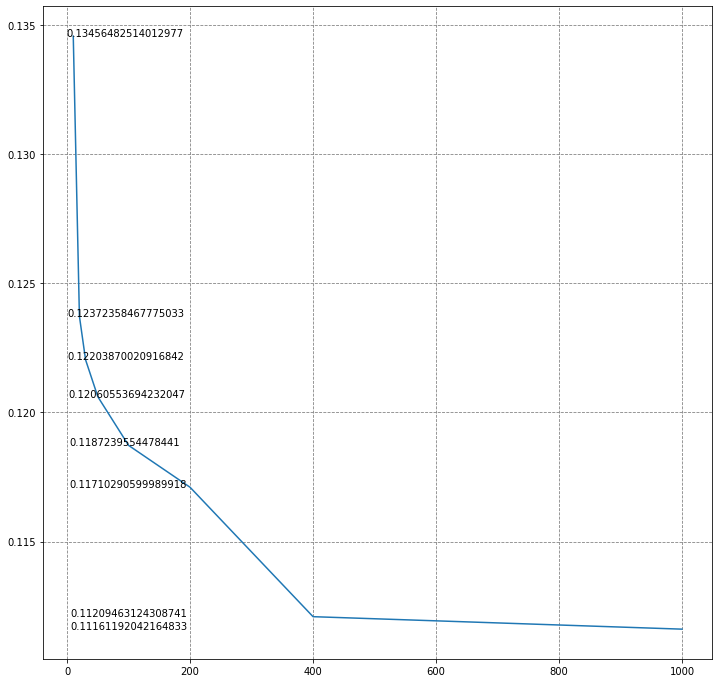

In [ ]:
x = df_agg["epochs"]
y = df_agg["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
addlabels(x,y,ax)
plt.show()

### View one sample image from original set and predicted set and visually check quality

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_perf.to_csv('df_perf.csv')

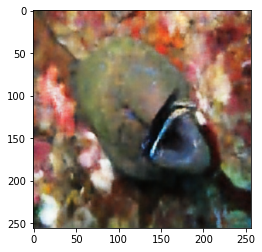

In [ ]:
plt.imshow(pred_arr_img_256[0])
plt.show()

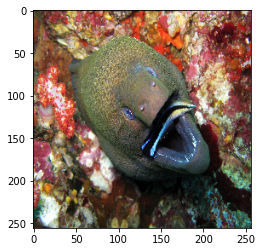

In [ ]:
plt.imshow(arr_img_256[0])
plt.show()

### From above images, we can visually confirm that the reconstructed image is quite good. If we train the network with more epochs the reconstructed image might have been much better

### Now, let's test the model on Val set

In [ ]:
val_img_64 = []
val_img_256 = []

In [ ]:
for file in os.listdir("/content/Val_Size_64"):
  img = tf.keras.utils.load_img(os.path.join("/content/Val_Size_64",file))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  val_img_64.append(img)

In [ ]:
for file in os.listdir("/content/Val_Size_256"):
  img = tf.keras.utils.load_img(os.path.join("/content/Val_Size_256",file))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  val_img_256.append(img)

In [ ]:
arr_val_img_64 = np.array(val_img_64)
arr_val_img_256 = np.array(val_img_256)

In [ ]:
arr_val_img_64.shape, arr_val_img_256.shape

((100, 64, 64, 3), (100, 256, 256, 3))

### Reconstructing the val dataset images

In [ ]:
pred_arr_val_img_256 = autoencoder.predict(arr_val_img_64)

4/4 [==============================] - 1s 214ms/step


### Now, let's find RMSE error of the generated image

In [ ]:
df_val_perf = pd.DataFrame(columns=["Model","LossFunction","Optimizer","epochs","Img_id","Error_Method","Error"])

In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_val_img_256.shape[0])):
  #print(i)
  pred_arr_val_img_256_1d = pred_arr_val_img_256[i].ravel()
  arr_val_img_256_1d = arr_val_img_256[i].ravel()
  rmse = find_rmse(pred_arr_val_img_256_1d, arr_val_img_256_1d)

  df_val_perf = pd.concat([df_val_perf,pd.DataFrame(
                                                    {
                                                      "Model" : "Autoencoder 1"
                                                      ,"LossFunction" : "RSME"
                                                      ,"Optimizer" : "adam"
                                                      ,"epochs" : 1000
                                                      ,"Img_id" : [i]
                                                      ,"Error_Method":"RSME"
                                                      ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 100/100 [00:02<00:00, 34.04it/s]


### Checking mean RSME for val images

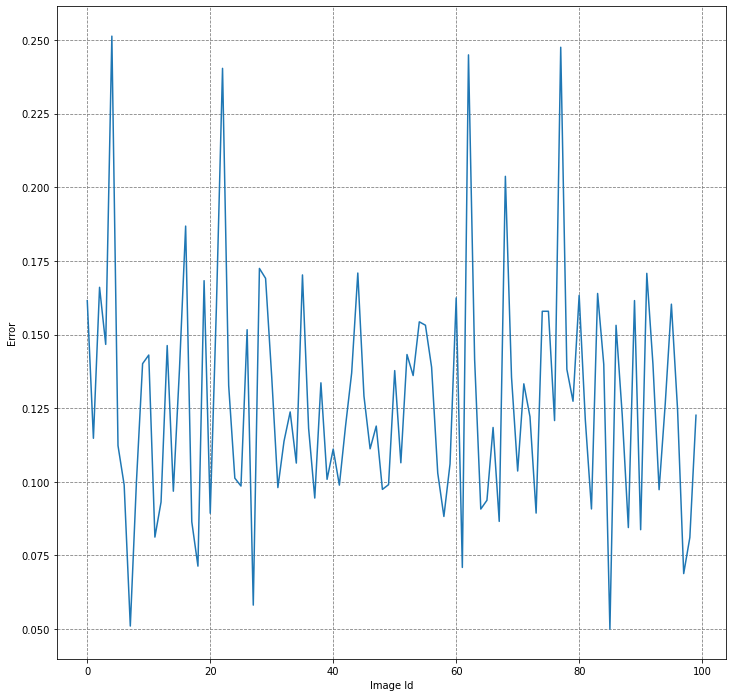

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(range(df_val_perf.shape[0]),df_val_perf["Error"])
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Image Id")
plt.ylabel("Error")
plt.show()

In [ ]:
df_val_agg = df_val_perf[["Error","epochs"]].groupby("epochs").agg(Mean_Error=("Error","mean")).reset_index().sort_values(by="Mean_Error")

In [ ]:
df_val_agg

,epochs,Mean_Error
0,1000,0.127551


In [ ]:
df_val_perf.shape[0]

100

### Let's check one image at to check the reconstructed image quality

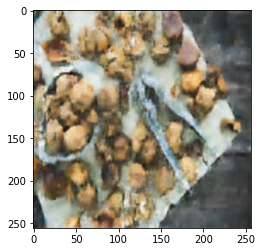

In [ ]:
plt.imshow(pred_arr_val_img_256[0])
plt.show()

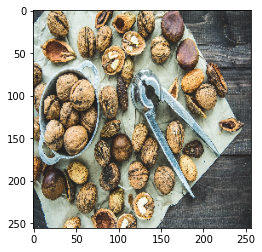

In [ ]:
plt.imshow(arr_val_img_256[0])
plt.show()

### Let's find the image, that has minimum loss

In [ ]:
#df_val_perf[["Error","Img_id"]].groupby("Img_id").agg(Min_Error=("Error","min")).reset_index().sort_values(by="Min_Error")
df_val_perf[df_val_perf["Error"] == df_val_perf["Error"].min()]

,Model,LossFunction,Optimizer,epochs,Img_id,Error_Method,Error
0,Autoencoder 1,RSME,adam,1000,85,RSME,0.049953


In [ ]:
Min_img_id = df_val_perf[df_val_perf["Error"] == df_val_perf["Error"].min()].loc[:,"Img_id"][0]
print(Min_img_id)

85


## From above analysis we see that Image 74 has minimum loss. Hence let's check the reconstructed image and original image and visually check the qualities of those images

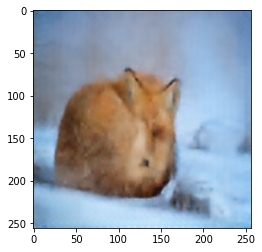

In [ ]:
plt.imshow(pred_arr_val_img_256[Min_img_id])
plt.show()

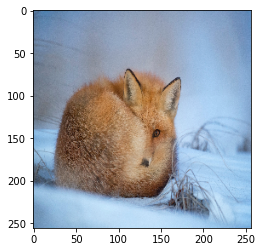

In [ ]:
plt.imshow(arr_val_img_256[Min_img_id])
plt.show()

### We find that the sharpness of the reconstructed image is somewhat degraded

### Got perceptual loss function from following URL
https://stackoverflow.com/questions/65484420/define-custom-loss-perceptual-loss-in-cnn-autoencoder-with-pre-train-vgg19-ten

In [ ]:
from keras.applications.vgg19 import VGG19
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv4']
selected_layer_weights = [1.0, 4.0 , 4.0 , 8.0 , 16.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0
    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)

    return rc_loss

### I used above code and the updated the code so that it uses autoencoder, instead of VGG19

In [ ]:
from keras.applications.vgg19 import VGG19

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv4']
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
outputs = [vgg.get_layer(l).output for l in selected_layers]

print(outputs)

[<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>, <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>, <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>, <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv3')>, <KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block5_conv4')>]


In [ ]:
autoencoder.compile(optimizer='adam', loss=perceptual_loss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 en_Conv1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 en_Pool1 (MaxPooling2D)     (None, 32, 32, 64)        0         
                                                                 
 en_Conv2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 dc_Conv2T (Conv2DTranspose)  (None, 64, 64, 128)      147584    
                                                                 
 dc_Conv3T (Conv2DTranspose)  (None, 128, 128, 128)    147584    
                                                                 
 dc_Conv4T (Conv2DTranspose)  (None, 256, 256, 64)     73792 

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=10)

Epoch 1/10
25/25 [==============================] - 37s 970ms/step - loss: 240110880.0000
Epoch 2/10
25/25 [==============================] - 23s 924ms/step - loss: 212229264.0000
Epoch 3/10
25/25 [==============================] - 23s 918ms/step - loss: 198586016.0000
Epoch 4/10
25/25 [==============================] - 23s 939ms/step - loss: 191637120.0000
Epoch 5/10
25/25 [==============================] - 23s 938ms/step - loss: 187850624.0000
Epoch 6/10
25/25 [==============================] - 23s 930ms/step - loss: 184455360.0000
Epoch 7/10
25/25 [==============================] - 23s 931ms/step - loss: 183844112.0000
Epoch 8/10
25/25 [==============================] - 23s 933ms/step - loss: 181878080.0000
Epoch 9/10
25/25 [==============================] - 23s 935ms/step - loss: 180098688.0000
Epoch 10/10
25/25 [==============================] - 23s 934ms/step - loss: 179241520.0000


In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 3s 104ms/step


In [ ]:
df_perf = pd.read_csv("df_perf.csv")
df_perf

,Unnamed: 0,Model,LossFunction,Optimizer,epochs,Img_id,Error_Method,Error
0,0,Autoencoder 1,RSME,adam,10,0,RSME,0.122580
1,0,Autoencoder 1,RSME,adam,10,1,RSME,0.152733
2,0,Autoencoder 1,RSME,adam,10,2,RSME,0.132709
3,0,Autoencoder 1,RSME,adam,10,3,RSME,0.143577
4,0,Autoencoder 1,RSME,adam,10,4,RSME,0.142966
...,...,...,...,...,...,...,...,...
6395,0,Autoencoder 1,RSME,adam,1000,795,RSME,0.172565
6396,0,Autoencoder 1,RSME,adam,1000,796,RSME,0.182968
6397,0,Autoencoder 1,RSME,adam,1000,797,RSME,0.069727
6398,0,Autoencoder 1,RSME,adam,1000,798,RSME,0.115097


In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        "Model" : "Autoencoder 2"
                                                        ,"LossFunction" : "Perceptual"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 10
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:28<00:00, 28.09it/s]


In [ ]:
df_agg = df_perf[["Model","Error","epochs"]].groupby(["Model","epochs"]).agg(Mean_Error=("Error","mean")).reset_index()
df_agg

,Model,epochs,Mean_Error
0,Autoencoder 1,10,0.134565
1,Autoencoder 1,20,0.123724
2,Autoencoder 1,30,0.122039
3,Autoencoder 1,50,0.120606
4,Autoencoder 1,100,0.118724
5,Autoencoder 1,200,0.117103
6,Autoencoder 1,400,0.112095
7,Autoencoder 1,1000,0.111612
8,Autoencoder 2,10,0.133388


In [ ]:
df_agg[df_agg["epochs"] == 10]

,Model,epochs,Mean_Error
0,Autoencoder 1,10,0.134565
8,Autoencoder 2,10,0.133388


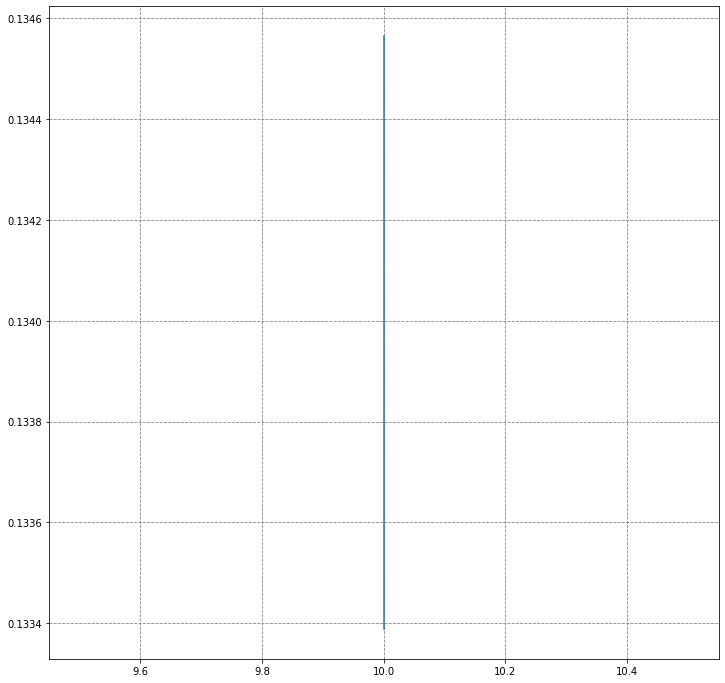

In [ ]:
x = [10,10]#df_agg[df_agg["epochs"] == 10]["epochs"]
y = df_agg[df_agg["epochs"] == 10]["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
#addlabels(x,y,ax)
plt.show()

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=20)

Epoch 1/20
25/25 [==============================] - 21s 854ms/step - loss: 178814656.0000
Epoch 2/20
25/25 [==============================] - 22s 867ms/step - loss: 178154624.0000
Epoch 3/20
25/25 [==============================] - 22s 876ms/step - loss: 177253952.0000
Epoch 4/20
25/25 [==============================] - 22s 885ms/step - loss: 176518656.0000
Epoch 5/20
25/25 [==============================] - 22s 896ms/step - loss: 175509376.0000
Epoch 6/20
25/25 [==============================] - 23s 905ms/step - loss: 174059824.0000
Epoch 7/20
25/25 [==============================] - 23s 919ms/step - loss: 173574064.0000
Epoch 8/20
25/25 [==============================] - 23s 929ms/step - loss: 173700592.0000
Epoch 9/20
25/25 [==============================] - 23s 936ms/step - loss: 173136960.0000
Epoch 10/20
25/25 [==============================] - 23s 933ms/step - loss: 171590912.0000
Epoch 11/20
25/25 [==============================] - 23s 931ms/step - loss: 171413280.0000
Epoch 12

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 101ms/step


In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        "Model" : "Autoencoder 2"
                                                        ,"LossFunction" : "Perceptual"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 20
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:30<00:00, 25.95it/s]


In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=30)

Epoch 1/30
25/25 [==============================] - 21s 854ms/step - loss: 167523008.0000
Epoch 2/30
25/25 [==============================] - 22s 861ms/step - loss: 167018832.0000
Epoch 3/30
25/25 [==============================] - 22s 874ms/step - loss: 167054688.0000
Epoch 4/30
25/25 [==============================] - 22s 883ms/step - loss: 166459104.0000
Epoch 5/30
25/25 [==============================] - 22s 893ms/step - loss: 165741008.0000
Epoch 6/30
25/25 [==============================] - 23s 902ms/step - loss: 165582368.0000
Epoch 7/30
25/25 [==============================] - 23s 913ms/step - loss: 164761392.0000
Epoch 8/30
25/25 [==============================] - 23s 924ms/step - loss: 164310256.0000
Epoch 9/30
25/25 [==============================] - 23s 932ms/step - loss: 163689568.0000
Epoch 10/30
25/25 [==============================] - 23s 932ms/step - loss: 164803536.0000
Epoch 11/30
25/25 [==============================] - 23s 930ms/step - loss: 164386672.0000
Epoch 12

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 102ms/step


In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        "Model" : "Autoencoder 2"
                                                        ,"LossFunction" : "Perceptual"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 30
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:26<00:00, 29.87it/s]


In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=50)

Epoch 1/50
25/25 [==============================] - 22s 882ms/step - loss: 158471456.0000
Epoch 2/50
25/25 [==============================] - 22s 894ms/step - loss: 157917264.0000
Epoch 3/50
25/25 [==============================] - 23s 906ms/step - loss: 158781904.0000
Epoch 4/50
25/25 [==============================] - 23s 915ms/step - loss: 159017792.0000
Epoch 5/50
25/25 [==============================] - 23s 926ms/step - loss: 160386944.0000
Epoch 6/50
25/25 [==============================] - 23s 937ms/step - loss: 158053376.0000
Epoch 7/50
25/25 [==============================] - 23s 932ms/step - loss: 157583808.0000
Epoch 8/50
25/25 [==============================] - 23s 937ms/step - loss: 156862976.0000
Epoch 9/50
25/25 [==============================] - 23s 935ms/step - loss: 158010352.0000
Epoch 10/50
25/25 [==============================] - 23s 935ms/step - loss: 157841536.0000
Epoch 11/50
25/25 [==============================] - 23s 932ms/step - loss: 156281856.0000
Epoch 12

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 2s 103ms/step


In [ ]:
#for i in range(pred_arr_img_256.shape[0]):
for i in tqdm(range(pred_arr_img_256.shape[0])):
  #print(i)
  pred_arr_img_256_1d = pred_arr_img_256[i].ravel()
  arr_img_256_1d = arr_img_256[i].ravel()
  rmse = find_rmse(pred_arr_img_256_1d, arr_img_256_1d)

  df_perf = pd.concat([df_perf,pd.DataFrame(
                                                    {
                                                        "Model" : "Autoencoder 2"
                                                        ,"LossFunction" : "Perceptual"
                                                        ,"Optimizer" : "adam"
                                                        ,"epochs" : 50
                                                        ,"Img_id" : [i]
                                                        ,"Error_Method":"RSME"
                                                        ,"Error" : [rmse]
                                                    }
                                                )
                            ]
                           )
  
  #print("RMSE for the file {0} is : {1}".format(i,rmse))

100%|██████████| 800/800 [00:27<00:00, 29.43it/s]


In [ ]:
df_perf1 = df_perf[df_perf["Model"] == "Autoencoder 1"]
df_perf2 = df_perf[df_perf["Model"] == "Autoencoder 2"]

In [ ]:
df_agg_1 = df_perf1[["Error","epochs"]].groupby(["epochs"]).agg(Mean_Error=("Error","mean")).reset_index()
df_agg_2 = df_perf2[["Error","epochs"]].groupby(["epochs"]).agg(Mean_Error=("Error","mean")).reset_index()

In [ ]:
df_agg_1

,epochs,Mean_Error
0,10,0.134565
1,20,0.123724
2,30,0.122039
3,50,0.120606
4,100,0.118724
5,200,0.117103
6,400,0.112095
7,1000,0.111612


In [ ]:
df_agg_2

,epochs,Mean_Error
0,10,0.133388
1,20,0.133219
2,30,0.134958
3,50,0.133593


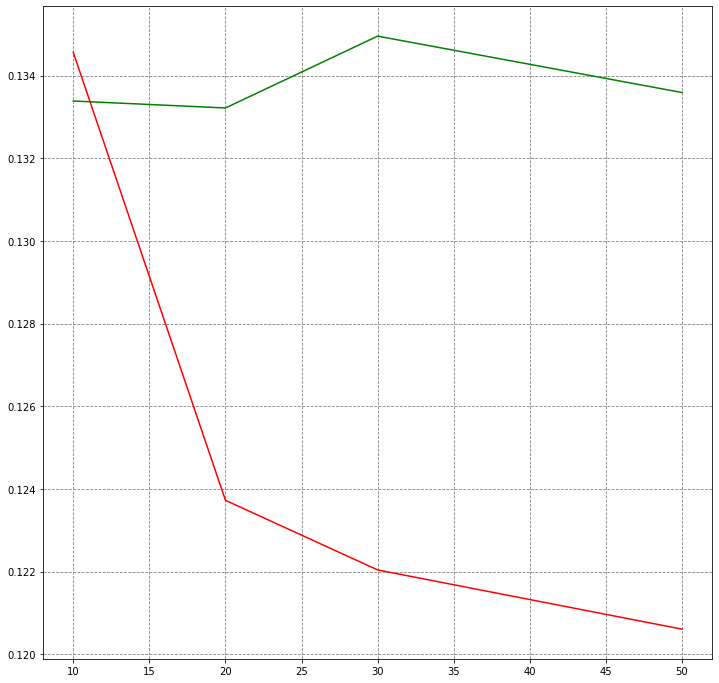

In [ ]:
x = df_agg_1.iloc[:4,:]["epochs"]
y1 = df_agg_1.iloc[:4,:]["Mean_Error"]
y2 = df_agg_2["Mean_Error"]
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(x,y1,color='r')
plt.plot(x,y2,color='g')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
#addlabels(x,y,ax)
plt.show()

In [ ]:
df_perf.to_csv("df_perf.csv")

In [ ]:
selected_layers = [layer.name for layer in autoencoder.layers]

outputs = [autoencoder.get_layer(l).output for l in selected_layers]
model = Model(autoencoder.input, outputs)

print(model)

In [ ]:
selected_layers = [layer.name for layer in autoencoder.layers]

outputs = [autoencoder.get_layer(l).output for l in selected_layers]
model = Model(autoencoder.input, outputs)


@tf.function
def perceptual_loss(input_image , reconstruct_image):
  h1_list = model(input_image)
  h2_list = model(reconstruct_image)

  rc_loss = 0.0
  for h1, h2 in zip(h1_list, h2_list):
    h1 = K.batch_flatten(h1)
    h2 = K.batch_flatten(h2)
    rc_loss = rc_loss + K.sum(K.square(h1 - h2), axis=-1)

  return rc_loss  

In [ ]:
autoencoder.compile(optimizer='adam', loss=perceptual_loss)

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=10)

Epoch 1/10


ValueError: ignored

In [ ]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv4']
selected_layer_weights = [1.0, 4.0 , 4.0 , 8.0 , 16.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0
    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)

    return rc_loss

In [ ]:
autoencoder.compile(optimizer='adam', loss=perceptual_loss)

In [ ]:
autoencoder.fit(arr_img_64,arr_img_256, epochs=20)

Epoch 1/20
25/25 [==============================] - 19s 755ms/step - loss: 252849168.0000
Epoch 2/20
25/25 [==============================] - 19s 765ms/step - loss: 246748688.0000
Epoch 3/20
25/25 [==============================] - 19s 774ms/step - loss: 246219616.0000
Epoch 4/20
25/25 [==============================] - 20s 783ms/step - loss: 242044720.0000
Epoch 5/20
25/25 [==============================] - 20s 787ms/step - loss: 239688064.0000
Epoch 6/20
25/25 [==============================] - 20s 783ms/step - loss: 237980624.0000
Epoch 7/20
25/25 [==============================] - 20s 781ms/step - loss: 237618784.0000
Epoch 8/20
25/25 [==============================] - 20s 784ms/step - loss: 233291728.0000
Epoch 9/20
25/25 [==============================] - 20s 784ms/step - loss: 231835184.0000
Epoch 10/20
25/25 [==============================] - 20s 788ms/step - loss: 231550880.0000
Epoch 11/20
25/25 [==============================] - 20s 783ms/step - loss: 229786624.0000
Epoch 12

In [ ]:
pred_arr_img_256 = autoencoder.predict(arr_img_64)

25/25 [==============================] - 1s 45ms/step


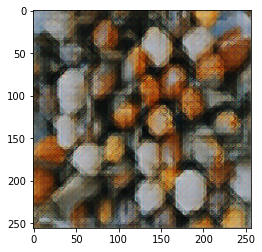

In [ ]:
plt.imshow(pred_arr_img_256[0])

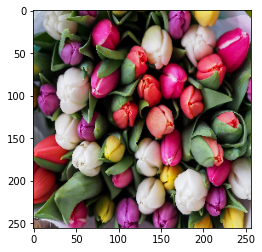

In [ ]:
plt.imshow(arr_img_256[0])